In [474]:
#Adapted from the Keras Example https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Week 6.1- Embeddings for Recommendation 

Here we'll see how to train our simple **Dot Product** model, along with our **user embeddings** and **item embeddings** using the **Keras** library. As before, we'll be checking out the **MovieLens** dataset 

## Loading in the Dataset

First we load in the small version of the dataset. As this is a **Collaborative Filtering** approach, we are interested in the **ratings.csv**, which has all over ratings made by each user.

In [2]:
df = pd.read_csv("data/ml-latest-small/ratings.csv")

In [3]:
len(df)

100004

In [4]:
df.tail(100)

,userId,movieId,rating,timestamp
99904,671,590,4.0,1065149296
99905,671,608,4.0,1064890575
99906,671,745,4.0,1065149085
99907,671,919,4.0,1065149458
99908,671,1035,5.0,1065149492
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


## Preprocessing 

What we have in the dataset is a list of **userId** and **movieId** pairs loaded into a ``Pandas`` DataFrame. 

As we said before, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

When we make the embedding, we will need a way of mapping back from **indexes** in the **one-hot encoding** back to the ids for the users and movies. 

### Vocabulary 

In order to make the vocabulary (all the unique ids), we can use the ``unique()`` function in ``Pandas``

In [7]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [8]:
len(movie_ids)

9066

In [9]:
#Non-sequential list of ids
movie_ids[:6]

[31, 1029, 1061, 1129, 1172, 1263]

### Dictionary Comprehensions 

We've seen ``Dictionaries`` (e.g. when looking at JSON from REST APIs). This is a collection like a ``List``, but instead of using indexes to access data (**values**), we use **keys**. 

We've also seen ``List Comprehensions``, a short hand way to iterate through an existing collection and make a new ``List``. 

As we want something where we can use an arbitrary string/number (e.g. a movie or user id) to look up an index, a ``Dictionary`` seems like a good data structure to use. We can declare dictionaries manually (see below), but it would be much quicker and cleaner to use the information we already have to make this.


In [10]:
#Manually making the dictionary
movie_id_to_index = {
    31: 1,
    1029: 2,
    1061: 3
}
#Use a movie id to look up an index
movie_id_to_index[31]

1

Like the ``List Comprehension``, the ``Dictionary Comprehension`` iterates through a given collection, does some calculation and stores new values in a new collection. 

In this case, we need to return both a ``Key`` and a ``Value`` for each item. 

```
a = [1,2,3]
b = {i:i+1 for i in a} 
```

is the same as 

```
a = [1,2,3]
b = {}
for i in a:
    b[i] = i+1
```

where we end up with the ``Dictionary``

```
{
    1: 2,
    2: 3,
    3: 4
}
```

Below, we combine the dictionary comprehension with the ``enumerate()`` function to return the id (x) and the index (i) and store them in a new dictionary 

In [11]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [12]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [13]:
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4


### Scaling the ratings

As is good when working with ``gradient descent``, it helps to have our values on a similar range, and for that to be between 0 and 1. We can use the ``MinMaxScaler`` from ``Scikit-Learn`` to scale our ratings to between 0 and 1

In [14]:
df["rating"].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [15]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [16]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

## Training Set

We are making a **predictive model** that will take a **user** and **movie** and return a **rating**. 

For our training, we will make a dataset using the information we already know. In this context, our input feautres (``x``) are the movie and user indexes, and the our output (``y``) is the rating. 

We make a train - test split of ``10%`` to validate our model. 

In [2]:
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

NameError: name 'df' is not defined

## Making a Custom Model 

Previously in ``Keras`` we have used to pre-existing layers, connecting them all together in using the [Sequential](https://keras.io/guides/sequential_model/) object. This allows us to fit together layers that pass information forwards in a structure that works for most **Neural Networks**.

Partly for reasons of broadening our horizons, and partly due to many Tensorflow based issues, we are going to introduce you to what is fastly becoming the most popular machine learning library, ``PyTorch``. 

Luckily for us, the API (the functions, the structure of models etc..) are very similar across a lot of the leading libraries.

``PyTorch`` has a [Module]() object which we can **subclass**. Without getting too bogged down in the details of **Object Oriented Programming**, essentially what this means is we can take the **existing functionality** from this object and **override** certain functions to add in custom behaviour.

Using the ``Module`` structure, we have something that can take advantage of a lot the things that are built into the ``PyTorch`` library. It can be trained, can have layers, can have parameters that can be optimised.

**But**, we can also add in our own functionality. 

The two main functions we want to override and these are 

1. ``def __init__()``
    
    * This is called **once** when the object is first made. We can use this to define our layers 
    

2. ``def forward()``

    * This is called everytime we want to make a forwards pass. This means it takes some **inputs** and returns some **outputs**. This is called during training, or for inference on a trained model. 
    
### LouisNet

Below, we show an **incredibly simple model**, but it should help you get an intuition for what function is called at when in the training process

We can see the ``__init__()`` is called once, and then the ``call()`` is called **once per batch**, where we get the inputs for this batch and return some outputs

This model doesnt actually have any parameters to train, its more to demonstrate the subclassing principle in the simplest terms

In [16]:
#Install libraries (only do this once!)
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 4.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 6.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 5.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 16.7 MB/s eta 0:00:00


In [18]:
#import library
import torch

In [19]:
#Define class and subclass torch.nn.Module
class LouisNet(torch.nn.Module):
    
    #Override __init__()
    def __init__(self):
        super().__init__()
        print("__init__ called")
    
    #Override forward()
    def forward(self, inputs):
        print("\nforwards pass (new batch)")
        print(inputs,"\n")
        #return the output (its just the input, unchanged)
        return inputs

#Make a new instance of LouisNet    
louisNet = LouisNet()
loss_fn = torch.nn.MSELoss() 

#Fake dataset
x = torch.FloatTensor([[1],[2],[3],[4]])
y = torch.FloatTensor([[2],[3],[4],[5]])

#Do a forwards pass
prediction = louisNet(x)
loss = loss_fn(prediction, y)

__init__ called

forwards pass (new batch)
tensor([[1.],
        [2.],
        [3.],
        [4.]]) 



## The Dot Product Recommender Model

Lets remember the model we're trying to make. 


```
Predicted Rating = Dot Product(user_vector, item_vector) + user_bias + item_bias
```


Our target is to find a vector for each movie and user so that their dot product (+ their biases) is an accurate prediction for the rating that user would make for that movie. 

Each of these vectors will be contained in a matrix, that we call an **embedding**


### The Embedding Layer 

Again, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

Luckily, ```PyTorch``` has a layer already we can use, all we have to say is 

1. How many items we have (vocabulary size)

2. The size of the embedding 

You might use something between 10-300, and this is something you will have to tune

### New Arguments for ``__init__``

Again, we will override the ```__init__()``` function, but this time we will add in some extra arguments. We can use this to pass in 

1. Number of users 

2. Number of movies

3. Size of Embedding

These get passed in when we make the new object 

```
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

```

### Saving Variables and ```self```

Finally, the last **Object-oriented** concept we'll need allows us to save things within the object. These are sometimes called ``instance variables`` or ``fields``, but the main thing you need to know is **these are like the variables we use all the time to store objects and data**, apart from they belong to the object, and only work within this context 

We use the keyword ```self``` within the object to refer to itself. We can use this to make layers in the ```__init__()``` function, store them in the object, and then reuse and update them in the ```forward()``` function.


On every forwards pass (see ``forward()`` below)

1. We take a batch of ``users`` and ``movies``


2. Run them through the normal embedding and bias embedding layers respectively 


3. Get the vectors for each out 


4. Get the dot product of the user and movie vectors 


5. Add the biases 


6. Run through a sigmoid


7. Return!

In [1]:
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

NameError: name 'torch' is not defined

## Lets test it!

### Set up model

In [21]:
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

### Training and Datasets in PyTorch

PyTorch requires a little bit of manual set up for the training loop that we got for free in ``Keras`` with the ``fit()`` function. 

Below we see two for loops, one that loops round every epoch (once through the entire dataset) and inside that that loops through each batch (a subset of a chosen size).

``PyTorch`` gives us a ``DataLoader`` object which helps with the batching process.

Within that inner loop we pass in part of the training set, calculate the loss and update the weights based on this. 


In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values,y_val.values), batch_size=64, shuffle=True)

In [24]:
epochs = 10
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [25]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.17091104388237 Validation Loss 0.11452551186084747
Loss 0.0769750326871872 Validation Loss 0.08216816931962967
Loss 0.04859926924109459 Validation Loss 0.06941480934619904
Loss 0.03727338835597038 Validation Loss 0.06458643078804016
Loss 0.0313669852912426 Validation Loss 0.06311647593975067
Loss 0.02760489284992218 Validation Loss 0.06218786910176277
Loss 0.025336744263768196 Validation Loss 0.06296209245920181
Loss 0.023756243288517 Validation Loss 0.06204921752214432
Loss 0.022566072642803192 Validation Loss 0.06253045052289963
Loss 0.021713625639677048 Validation Loss 0.06210881099104881


### Save and Reload models

We can save the weights of our model (the important parts that we have learned) to file so we don't have to train again in future

We can then load them into a new model from file. 

In [26]:
torch.save(model.state_dict(), 'model_weights.pth')

In [27]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

### Accessing the Embeddings 

We can access the **embedding layers** in our model object. This is the embedding and we can see is has a shape of ```num_users x EMBEDDING_SIZE```

In [28]:
num_users, EMBEDDING_SIZE, model.user_embedding

(671, 16, Embedding(671, 16))

### Making Predictions 

Now, we can use our trained model to make predictions, and with the predicted ratings, we can pick some recommendations!

In order to get the ratings for all movies for a given user, we need to get pass in our data in the form 

```
[
    [user_index, movie_1_index],
    [user_index, movie_2_index],
    [user_index, movie_3_index],
    .....
]

```

In [29]:
#Get the movie data so we can map back to names
movie_data = pd.read_csv("data/ml-latest-small/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

### Making predictions and `argsort()`

Once we have the predicted ratings for each film, we need to get the **Top N**

Here we use `np.argsort()`, which does the sort based on the **ratings** but returns the **indexes** rather than the **ratings themselves**. We can then use this to look up the `movie_ids` and then the `title`.

In [30]:
def get_top_n(user = 0, n = 10): 
    #Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict 
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes

In [31]:
#Random users top 10
get_top_n(np.random.randint(num_users))

['Vagabond (Sans toit ni loi) (1985)',
 'Rivers and Tides (2001)',
 'Naked (1993)',
 'Listen to Me Marlon (2015)',
 'Kingdom, The (Riget) (1994)',
 "Shall We Kiss? (Un baiser s'il vous plait) (2007)",
 'Lured (1947)',
 'Goodbye, Columbus (1969)',
 "Gentleman's Agreement (1947)",
 'Force of Evil (1948)']

# Assessed Assignment 2

Please remember to comment your code clearly, submit ``.ipynb`` 

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (inverse of the similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, get the embedding for each film then use this to calculate the similarity matrix


3. Invert similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)


### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).



## Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

## Assignment 2 - My Codes

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch

In [2]:
df = pd.read_csv("data/ml-latest-small/ratings.csv")
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [3]:
len(movie_ids)

9066

In [4]:
# Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [5]:
# Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [6]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

In [7]:
df.to_csv('data/processed_ratings.csv', index=False)

In [8]:
# 这一段是读取之前处理过的数据，这样重复运行的时候就不用重新跑一遍上面的部分了
df = pd.read_csv('data/processed_ratings.csv')
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,0.444444,1260759144,0,0
1,1,1029,0.555556,1260759179,0,1
2,1,1061,0.555556,1260759182,0,2
3,1,1129,0.333333,1260759185,0,3
4,1,1172,0.777778,1260759205,0,4


In [9]:
# 这里再定义一遍是为了不用跑到最顶上找对应的代码块
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

In [10]:
# 模型的必要的设置不能省略
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

In [11]:
# 加载之前的模型参数，用模型做推理才能得到embedding
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

In [12]:
# Get the movie data so we can map back to names
movie_data = pd.read_csv("data/ml-latest-small/movies.csv")
print(movie_data.columns)
print(len(movie_data['movieId']))

Index(['movieId', 'title', 'genres'], dtype='object')
9125


In [13]:
def get_top_n(user = 0, n = 10):
    #Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes

Task1, Diversity

In [14]:
from torch.nn.functional import cosine_similarity

user_indexs = df["user_index"].unique().tolist()
# print(len(user_indexs))  # 671
user_diffs = {}

for user in user_indexs:
    # 1 Calculate every user's top 10
    top_10_indexes = get_top_n_indexes(user, n=10)
    # 2 get the embeddings
    movie_embeddings = model.movie_embedding(top_10_indexes)
    # print(movie_embeddings.shape)  # (10, 16)

    # calculate the similarity matrix
    similarity_matrix = torch.zeros((10, 10))
    for i in range(10):
        for j in range(i+1):
            similarity_matrix[i][j] = cosine_similarity(movie_embeddings[i].unsqueeze(0), movie_embeddings[j].unsqueeze(0))
            similarity_matrix[j][i] = similarity_matrix[i][j]
    # print(similarity_matrix.shape)  # torch.Size([10, 10])
    # 3 Invert similarity to get the difference
    diff_matrix = torch.ones((10, 10))
    diff_matrix = diff_matrix - similarity_matrix
    # print(diff_matrix)
    # 4 Get mean difference for each top 10
    mean_diff = torch.mean(diff_matrix, dim=1)  # top10中的每部电影，与其他电影的平均差异
    # print(mean_diff)
    user_diffs[user] = torch.mean(mean_diff, dim=0)  # 每个user的喜爱电影top10的均值


# 5 Report the mean for whole dataset (every top 10)
mean_all_top_10 = 0
for user in user_diffs.keys():
    mean_all_top_10 += user_diffs[user]

print("the mean for whole dataset (every top 10): ", mean_all_top_10.item() / len(user_diffs))  # 所有user的喜爱电影top10的均值的均值

the mean for whole dataset (every top 10):  0.5939980064881007


Task1, Novelty

In [15]:
# get the mean rating for all films (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``).
df_ratings = pd.read_csv("data/ml-latest-small/ratings.csv")

dict = {}  # dictionary for mean ratings of films
average_ratings = df_ratings.groupby('movieId')['rating'].mean()
for movie_id, average_rating in average_ratings.iteritems():
    movie_name = movie_data[movie_data["movieId"] == movie_id]["title"].item()
    if not movie_name in dict.keys():
        dict[movie_name] = average_rating  # 存储所有电影的平均分数

In [16]:
ser_indexs = df["user_index"].unique().tolist()
# print(len(user_indexs))  # 671
user_novelty = {}

for user in user_indexs:
    # 1. Calculate every user's top 10
    movie_names = get_top_n(0, n=10)  # we need movies' name here
    # print(movie_names)
    # 2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 该步骤在上一个代码块中已经完成，不需要为每个user单独做一次
    # for movie_name in movie_names:
    #     print(dict[movie_name])
    # 3. Get the mean rating for each top 10.
    mean_rating = 0
    for movie_name in movie_names:
        mean_rating += dict[movie_name]
    user_novelty[user] = mean_rating / 10.
    # print(mean_rating)

# 4. Report the mean for the whole dataset (every top 10).
mean_all_top_10_rating = 0
for user in user_novelty.keys():
    mean_all_top_10_rating += user_novelty[user]

print("the mean for whole dataset (every top 10): ", mean_all_top_10_rating / len(user_novelty))  # 所有user的喜爱电影top10的评分均值的均值

the mean for whole dataset (every top 10):  4.315317460317478


Task 2

In [17]:
df = pd.read_csv("data/processed_ratings.csv")

threshold = 20  # 评分条数少于阈值的电影会被丢弃
movie_counts = df['movieId'].value_counts()
filtered_movieIds = movie_counts[movie_counts >= threshold].index
filtered_df = df[df['movieId'].isin(filtered_movieIds)]
print(len(df), len(filtered_df))
print(filtered_df.head(5))

100004 69104
   userId  movieId    rating   timestamp  user_index  movie_index
0       1       31  0.444444  1260759144           0            0
1       1     1029  0.555556  1260759179           0            1
2       1     1061  0.555556  1260759182           0            2
3       1     1129  0.333333  1260759185           0            3
4       1     1172  0.777778  1260759205           0            4


In [18]:
movie_ratings = {}  # dictionary for mean ratings of films
average_ratings = filtered_df.groupby('movieId')['rating'].mean()
for movie_id, average_rating in average_ratings.iteritems():
    if not movie_id in movie_ratings.keys():
        movie_ratings[movie_id] = average_rating  # 存储所有电影的平均分数
        # 这里用movie_id，方便后续进行比较，最后再转化成movie_name

print(len(movie_ratings))  # 剩余1303部电影

1303


In [19]:
# 本代码块创建一个将id转化为index的字典

# 将 "movieId" 列设置为索引
filtered_df = filtered_df.set_index('movieId')
# 将索引列和 "movie_index" 列转换为字典
id_to_index_dict = filtered_df['movie_index'].to_dict()

In [20]:
print(id_to_index_dict[356])  # 测试字典的正确性

57


In [21]:
top_30_movies = sorted(movie_ratings.items(), key=lambda x: x[1], reverse=True)[:30]  # 评分前三十的电影

# 打印分数最高的 30 部电影
for movie_id, rating in top_30_movies:
    print("Movie ID:", movie_id, "- Rating:", rating)

Movie ID: 858 - Rating: 0.88611111111111
Movie ID: 318 - Rating: 0.8860307252590197
Movie ID: 1945 - Rating: 0.8773946360153259
Movie ID: 926 - Rating: 0.8742690058479534
Movie ID: 1217 - Rating: 0.8717948717948718
Movie ID: 969 - Rating: 0.8711111111111113
Movie ID: 2064 - Rating: 0.8650793650793654
Movie ID: 913 - Rating: 0.8637992831541221
Movie ID: 7502 - Rating: 0.8636363636363636
Movie ID: 1221 - Rating: 0.863374485596707
Movie ID: 905 - Rating: 0.8622222222222224
Movie ID: 50 - Rating: 0.8601437258153661
Movie ID: 3462 - Rating: 0.8576388888888891
Movie ID: 898 - Rating: 0.8558558558558561
Movie ID: 1228 - Rating: 0.8555555555555556
Movie ID: 1252 - Rating: 0.8523391812865498
Movie ID: 2318 - Rating: 0.85024154589372
Movie ID: 904 - Rating: 0.8478260869565216
Movie ID: 3730 - Rating: 0.8454106280193238
Movie ID: 1203 - Rating: 0.8453453453453457
Movie ID: 527 - Rating: 0.8451730418943517
Movie ID: 1254 - Rating: 0.8444444444444447
Movie ID: 6016 - Rating: 0.8438003220611912
Movi

In [22]:
print(top_30_movies[0])  # 观察内容是否正确
top_30_movie_names = [id_to_index_dict[k[0]] for k in top_30_movies]  # # k是一个元组，第一个元素是movie id，第二个元素是movie rating
top_30_movie_names = get_names_for_indexes(top_30_movie_names)
print(top_30_movie_names)  # 观察是否正确转化为名称

(858, 0.88611111111111)
['Godfather, The (1972)', 'Shawshank Redemption, The (1994)', 'On the Waterfront (1954)', 'All About Eve (1950)', 'Ran (1985)', 'African Queen, The (1951)', 'Roger & Me (1989)', 'Maltese Falcon, The (1941)', 'Band of Brothers (2001)', 'Godfather: Part II, The (1974)', 'It Happened One Night (1934)', 'Usual Suspects, The (1995)', 'Modern Times (1936)', 'Philadelphia Story, The (1940)', 'Raging Bull (1980)', 'Chinatown (1974)', 'Happiness (1998)', 'Rear Window (1954)', 'Conversation, The (1974)', '12 Angry Men (1957)', "Schindler's List (1993)", 'Treasure of the Sierra Madre, The (1948)', 'City of God (Cidade de Deus) (2002)', 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', 'Smoke (1995)', 'Blood Simple (1984)', 'Seven Samurai (Shichinin no samurai) (1954)', 'Cool Hand Luke (1967)', 'Killing Fields, The (1984)', 'North by Northwest (1959)']


In [23]:
# 下面开始获取每部电影对应的embedding
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

In [24]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

In [25]:
movie_embeddings = []
for k in top_30_movies:  # 要得到电影的embedding，输入应该是movie_index
    print(k)  # k是一个元组，第一个元素是movie id，第二个元素是movie rating
    movie_vector = model.movie_embedding(torch.tensor(id_to_index_dict[k[0]]))
    movie_embeddings.append(movie_vector)

(858, 0.88611111111111)
(318, 0.8860307252590197)
(1945, 0.8773946360153259)
(926, 0.8742690058479534)
(1217, 0.8717948717948718)
(969, 0.8711111111111113)
(2064, 0.8650793650793654)
(913, 0.8637992831541221)
(7502, 0.8636363636363636)
(1221, 0.863374485596707)
(905, 0.8622222222222224)
(50, 0.8601437258153661)
(3462, 0.8576388888888891)
(898, 0.8558558558558561)
(1228, 0.8555555555555556)
(1252, 0.8523391812865498)
(2318, 0.85024154589372)
(904, 0.8478260869565216)
(3730, 0.8454106280193238)
(1203, 0.8453453453453457)
(527, 0.8451730418943517)
(1254, 0.8444444444444447)
(6016, 0.8438003220611912)
(922, 0.8433048433048436)
(194, 0.8425925925925929)
(3683, 0.8425925925925927)
(2019, 0.8395061728395062)
(1276, 0.8381642512077295)
(1299, 0.8380952380952381)
(908, 0.8378033205619412)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [27]:
# 使用 PCA 进行降维，将嵌入向量降至 2 维
movie_embeddings_array = np.array([movie_embedding.detach().numpy() for movie_embedding in movie_embeddings])
pca = PCA(n_components=2)
movie_embeddings_2d = pca.fit_transform(movie_embeddings_array)

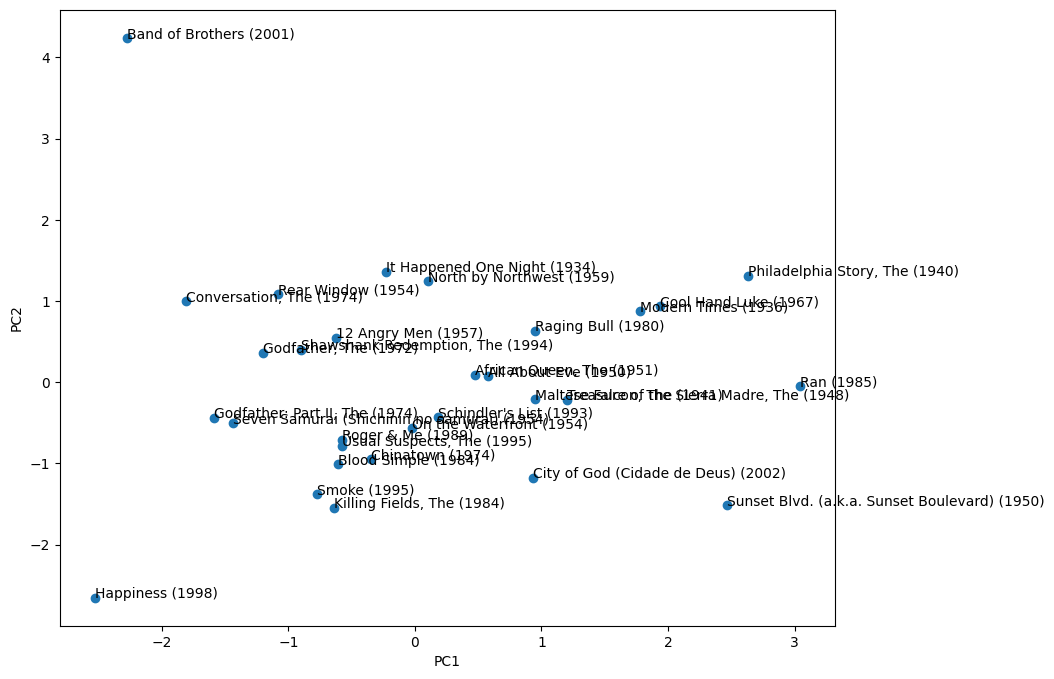

In [28]:
# 创建一个新的图形
plt.figure(figsize=(10, 8))

# 绘制散点图，并将电影名称标注在每个点上
plt.scatter(movie_embeddings_2d[:, 0], movie_embeddings_2d[:, 1])
for i, movie_name in enumerate(top_30_movie_names):
    plt.annotate(movie_name, (movie_embeddings_2d[i, 0], movie_embeddings_2d[i, 1]))

# 设置坐标轴标签
plt.xlabel('PC1')
plt.ylabel('PC2')

# 显示图形
plt.show()